In [1]:
import json
import os
import argparse

import numpy as np
import random
import torch
from torch import nn, optim
from tqdm.auto import tqdm
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from pathlib import Path
from torch.utils.data import DataLoader, Subset
import sys
sys.path.append('../lib/exlib/src')
sys.path.insert(0, '../lib/pytorch-grad-cam')
from exlib.modules.sop import SOPImageCls, SOPConfig, get_chained_attr

SystemError: initialization of _internal failed without raising an exception

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 42
if SEED != -1:
    # Torch RNG
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # Python RNG
    np.random.seed(SEED)
    random.seed(SEED)

In [ ]:
# model paths
# backbone_model_name = '../pt_models/vit-base-patch16-224-imagenet10cls'
backbone_model_name = 'google/vit-base-patch16-224'
backbone_processor_name = 'google/vit-base-patch16-224'
# sop_config_path = 'configs/imagenet_m.json'

# data paths
TRAIN_DATA_DIR = '../data/imagenet_m/train'
VAL_DATA_DIR = '../data/imagenet_m/val'

# training args
batch_size = 16
lr = 0.000005
num_epochs = 20
warmup_steps = 2000
mask_batch_size = 64

# experiment args
exp_dir = '../exps/imagenet_m_2h/best'

In [ ]:
backbone_model = AutoModelForImageClassification.from_pretrained(backbone_model_name)
processor = AutoImageProcessor.from_pretrained(backbone_processor_name)
backbone_config = AutoConfig.from_pretrained(backbone_model_name)

config = SOPConfig()
config.update_from_json(os.path.join(exp_dir, 'config.json'))

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def transform(image):
    # Preprocess the image using the ViTImageProcessor
    image = image.convert("RGB")
    inputs = processor(image, return_tensors='pt')
    return inputs['pixel_values'].squeeze(0)

# Load the dataset
# train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
val_dataset = ImageFolder(root=VAL_DATA_DIR, transform=transform)

# Use subset for testing purpose
# num_data = 100
# train_dataset = Subset(train_dataset, range(num_data))
# val_dataset = Subset(val_dataset, range(num_data))

# Create a DataLoader to batch and shuffle the data
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return WrappedBackboneOutput(outputs.logits, outputs.hidden_states[-1][:,0])

In [ ]:
class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        # print('inputs', inputs.shape)
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [ ]:
wrapped_backbone_model = WrappedBackboneModel(backbone_model)
wrapped_backbone_model = wrapped_backbone_model.to(device)
class_weights = get_chained_attr(wrapped_backbone_model, config.finetune_layers[0]).weight #.clone().to(device)

In [ ]:
# model = SOPImageCls(config, wrapped_backbone_model, class_weights=class_weights, projection_layer=None)
# state_dict = torch.load(os.path.join(exp_dir, 'checkpoint.pth'))
# model.load_state_dict(state_dict['model'])
# model = model.to(device)
# model.eval();

In [ ]:
original_model = WrappedModel(backbone_model)
original_model = original_model.to(device)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
batch = next(iter(val_dataloader))
inputs, labels = batch
inputs, labels = inputs.to(device), labels.to(device)

## MFABA

In [12]:
from exlib.explainers.mfaba import MfabaImageCls

explainer = MfabaImageCls(original_model)
explainer = explainer.to(device)

In [13]:
expln_output = explainer(inputs, labels)
expln_output.attributions[0].shape

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


torch.Size([3, 224, 224])

### Test

In [14]:
import sys
sys.path.append('/shared_data0/weiqiuy/github/MFABA')

import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50, inception_v3, googlenet, vgg16, mobilenet_v2
from saliency.saliency_zoo import big, mfaba_cos, mfaba_norm, mfaba_sharp, mfaba_smooth, agi, ig, sm, sg,deeplift
from tqdm import tqdm
import torch
import numpy as np
import argparse
import torch
import random

In [15]:
model = resnet50(pretrained=True).eval().to(device)
sm = nn.Softmax(dim=-1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_layer = transforms.Normalize(mean, std)
sm = nn.Softmax(dim=-1)
model = nn.Sequential(norm_layer, model, sm).to(device)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [29]:
# img_batch = torch.load("data/img_batch.pt") # img_batch.shape = (1000,3,224,224)
# target_batch = torch.load("data/label_batch.pt") # target_batch.shape = (1000,)



batch_size = 128
attributions = []
# for i in tqdm(range(0, len(img_batch), batch_size)):
# img = img_batch[i:i+batch_size].to(device)
# target = target_batch[i:i+batch_size].to(device)
# attributions.append(mfaba_sharp(original_model, inputs, labels))
attributions.append(mfaba_sharp(model, inputs, labels))
if attributions[0].shape.__len__() == 3:
    attributions = [np.expand_dims(attribution, axis=0) for attribution in attributions]
attributions = np.concatenate(attributions, axis=0)

In [40]:
mfaba_sharp(original_model, inputs, labels).shape

(1, 3, 224, 224)

In [30]:
attributions.shape

(1, 3, 224, 224)

In [31]:
attributions[0].min(), attributions[0].max()

(-1.3815682e-08, 1.3893865e-08)

In [32]:
(attributions[0][0] == attributions[0][1])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

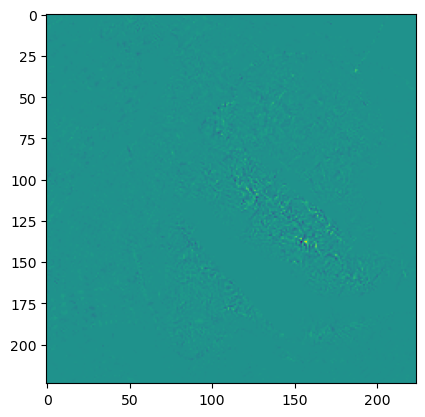

In [33]:
import matplotlib.pyplot as plt

plt.imshow(attributions[0].mean(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


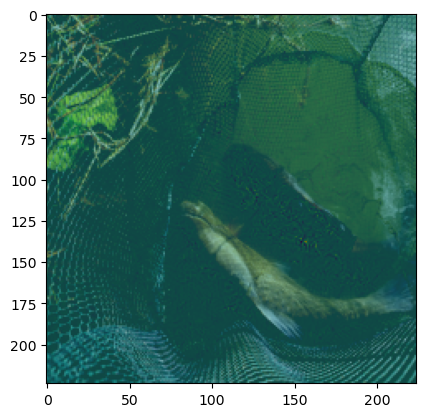

In [34]:
import matplotlib.pyplot as plt

plt.imshow(inputs[0].permute(1,2,0).cpu())
plt.imshow(attributions[0].mean(0), alpha=0.5)

In [35]:
import numpy as np

# Example attributions array (replace this with your actual attributions array)
# attributions = np.random.rand(1, 3, 224, 224)

# Calculate the mean of the attributions along the first axis (channels)
mean_attributions = attributions[0].mean(0)

# Flatten the mean attributions map
flattened_mean = mean_attributions.flatten()

# Sort the flattened array
sorted_flattened = np.sort(flattened_mean)

# Find the threshold value for the top 20%
threshold_index = int(len(sorted_flattened) * 0.8)
threshold_value = sorted_flattened[threshold_index]

# Create a mask to extract the top 20% values
top_20_percent_mask = mean_attributions >= threshold_value

# Apply the mask to the mean attributions to get the top 20% values
top_20_percent_values = mean_attributions[top_20_percent_mask]

# To get the indices of the top 20% values in the original 2D map
top_20_percent_indices = np.argwhere(top_20_percent_mask)

print("Top 20% values:")
print(top_20_percent_values)
print("Indices of top 20% values:")
print(top_20_percent_indices)


Top 20% values:
[1.18521318e-10 1.04995186e-10 2.28341610e-10 ... 1.50558621e-10
 1.63222283e-10 2.11220388e-10]
Indices of top 20% values:
[[  0   7]
 [  0  30]
 [  0  31]
 ...
 [223 140]
 [223 141]
 [223 170]]


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(inputs[0].permute(1,2,0).cpu())
plt.imshow(attributions[0].mean(0), alpha=0.5)

## AGI

In [12]:
from exlib.explainers.agi import AgiImageCls

explainer = AgiImageCls(original_model)
explainer = explainer.to(device)

expln_output = explainer(inputs, labels)
expln_output.attributions[0].shape

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


torch.Size([3, 224, 224])

### Test

In [30]:
model = original_model

In [31]:
import sys
root_dir = '/shared_data0/weiqiuy/github/AGI'
sys.path.append(root_dir)

# %%
# from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import cv2
from utils import Normalize, pre_processing

import json

In [32]:
epsilon = 0.05
use_cuda= True
device = torch.device("cuda:0" if (use_cuda and torch.cuda.is_available()) else "cpu")
max_iter = 15
topk = 15
selected_ids = range(0,999,int(1000/topk)) # define the ids of the selected adversarial class

class_idx = json.load(open(f"{root_dir}/imagenet_class_index.json"))
class_names = [class_idx[str(k)][1] for k in range(len(class_idx))]


In [33]:
#%%
def fgsm_step(image, epsilon, data_grad_adv, data_grad_lab):
    # generate the perturbed image based on steepest descent
    grad_lab_norm = torch.norm(data_grad_lab,p=2)
    delta = epsilon * data_grad_adv.sign()

    # + delta because we are ascending
    perturbed_image = image + delta
    perturbed_rect = torch.clamp(perturbed_image, min=0, max=1)
    delta = perturbed_rect - image
    delta = - data_grad_lab * delta
    return perturbed_rect, delta
    # return perturbed_image, delta

def pgd_step(image, epsilon, model, init_pred, targeted, max_iter):
    """target here is the targeted class to be perturbed to"""
    perturbed_image = image.clone()
    c_delta = 0 # cumulative delta
    for i in range(max_iter):
        # requires grads
        perturbed_image.requires_grad = True
        output = model(perturbed_image)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # if attack is successful, then break
        if pred.item() == targeted.item():
            break
        # select the false class label
        output = F.softmax(output, dim=1)
        try:
            loss = output[0,targeted.item()]
        except:
            import pdb; pdb.set_trace()
            
        model.zero_grad()
        loss.backward(retain_graph=True)
        data_grad_adv = perturbed_image.grad.data.detach().clone()

        loss_lab = output[0, init_pred.item()]
        model.zero_grad()
        perturbed_image.grad.zero_()
        loss_lab.backward()
        data_grad_lab = perturbed_image.grad.data.detach().clone()
        perturbed_image, delta = fgsm_step(image, epsilon, data_grad_adv, data_grad_lab)
        c_delta += delta
    
    return c_delta, perturbed_image

In [34]:
inputs.device

device(type='cuda', index=0)

In [39]:
data = pre_processing(inputs.cpu().numpy()[0].transpose(1,2,0), device)
data = data.to(device)
print(data.shape)

output = original_model(data)
init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

top_ids = selected_ids # only for predefined ids
# initialize the step_grad towards all target false classes
step_grad = 0 
# num_class = 1000 # number of total classes
for l in top_ids:
    targeted = torch.tensor([l]).to(device) 
    if targeted.item() == init_pred.item():
        continue # we don't want to attack to the predicted class.

    delta, perturbed_image = pgd_step(data, epsilon, model, init_pred, targeted, max_iter)
    step_grad += delta

adv_ex = step_grad.squeeze().detach().cpu().numpy() # / topk
img = data.squeeze().detach().cpu().numpy()

torch.Size([1, 3, 224, 224])


In [41]:
step_grad.shape

torch.Size([1, 3, 224, 224])

In [36]:
adv_ex.shape

(3, 224, 224)

In [52]:
(adv_ex[0] == adv_ex[1]).all()

False

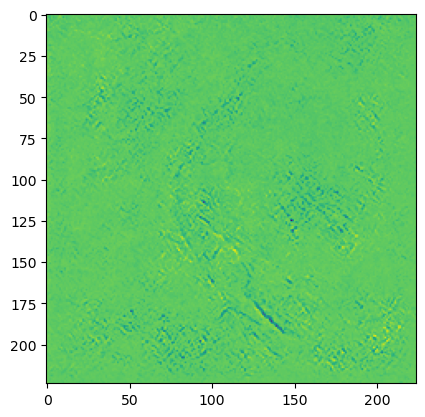

In [56]:
plt.imshow(adv_ex.mean(0))

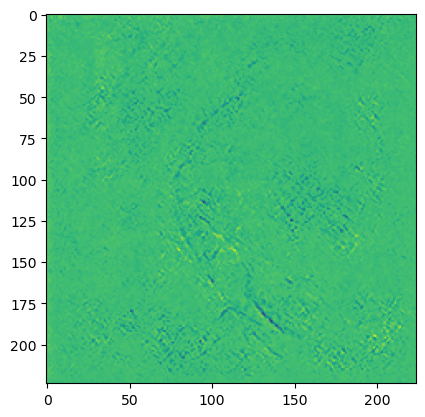

In [53]:
plt.imshow(adv_ex[0])

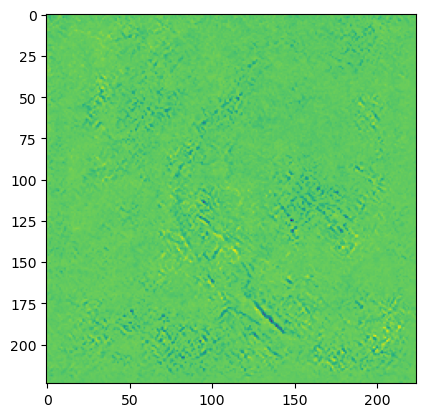

In [54]:
plt.imshow(adv_ex[1])

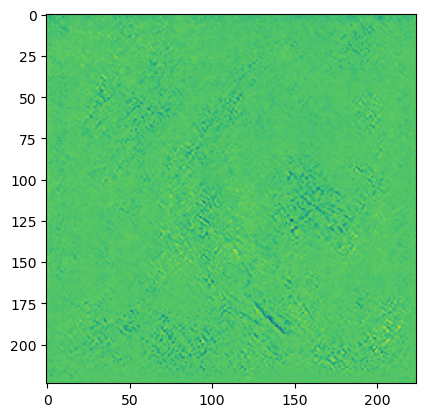

In [55]:
plt.imshow(adv_ex[2])

## AttEXplore

In [12]:
from exlib.explainers.ampe import AmpeImageCls

explainer = AmpeImageCls(original_model, N=5, num_steps=4)
explainer = explainer.to(device)

In [13]:
expln_output = explainer(inputs, labels)
expln_output.attributions[0].shape

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


torch.Size([3, 224, 224])

### Test

In [13]:
import sys
root_dir = '/shared_data0/weiqiuy/github/ATTEXPLORE'
sys.path.append(root_dir)

from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet50, inception_v3, googlenet, vgg16, mobilenet_v2
from saliency.saliency_zoo import big, big_ssa, agi, ig, sm, sg, deeplift,ampe
from saliency.saliency_zoo import fast_ig, guided_ig, eg, saliencymap,gradcam
from tqdm.auto import tqdm
import torch
import numpy as np
import argparse
import torch
import random

In [14]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [16]:
attexplore_attr = ampe(original_model, inputs, labels)

100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


In [26]:
attexplore_attr.shape

(1, 3, 224, 224)

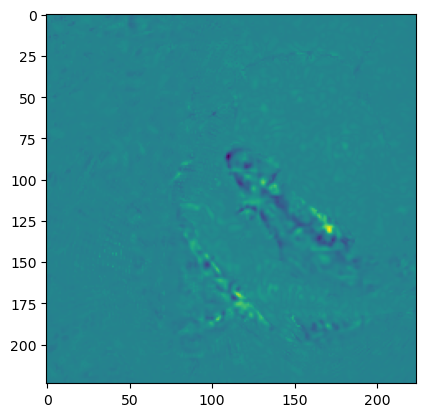

In [28]:
import matplotlib.pyplot as plt

plt.imshow(attexplore_attr[0][0])

## B-cos

In [28]:
from exlib.modules.bcos import BCos

model = BCos().to(device)
model.eval();

outputs = model((inputs + 1)/2)

Using cache found in /home/runai-home/.cache/torch/hub/B-cos_B-cos-v2_main


In [29]:
outputs.preds.shape, outputs.attributions.shape

(torch.Size([1]), torch.Size([1, 4, 224, 224]))

In [30]:
outputs.preds

tensor([0], device='cuda:0')

In [31]:
backbone_config.id2label[outputs.preds.item()]

'tench, Tinca tinca'

In [32]:
inputs.min(), inputs.max()

(tensor(-0.9686, device='cuda:0'), tensor(0.9765, device='cuda:0'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


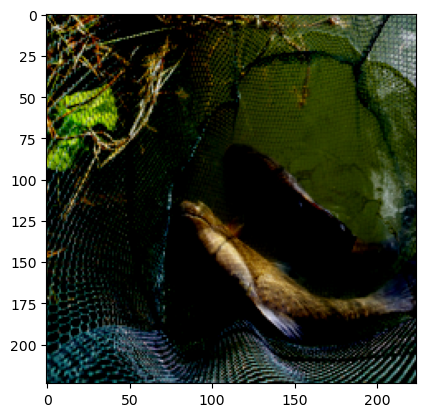

In [33]:
import matplotlib.pyplot as plt

plt.imshow(inputs[0].permute(1,2,0).cpu())

In [15]:
labels

tensor([0], device='cuda:0')

### Test

In [13]:
import torch

model = torch.hub.load('B-cos/B-cos-v2', 'simple_vit_b_patch16_224', pretrained=True)
model = model.to(device)
model.eval();

Using cache found in /home/runai-home/.cache/torch/hub/B-cos_B-cos-v2_main


In [17]:
# from torchvision import transforms
from bcos.data.transforms import AddInverse

images = inputs.clone().requires_grad_()
in_tensor = AddInverse()(images)

expln = model.explain(in_tensor.to(device))
attr = torch.tensor(expln['explanation']).permute(2,0,1)[None]

ValueError: Expected batch size of 1

In [15]:
expln.keys()

dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])

In [24]:
expln['prediction']

361

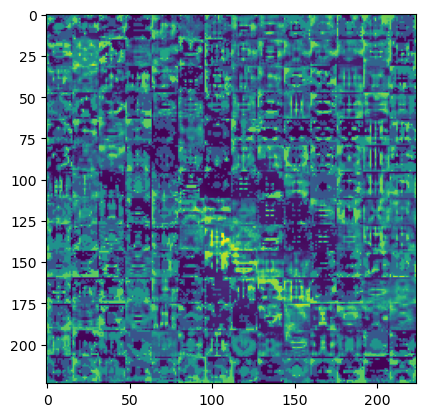

In [21]:
import matplotlib.pyplot as plt

plt.imshow(attr[0].mean(0))

### Test

In [31]:
import torch

# list all available models
torch.hub.list('B-cos/B-cos-v2')

# load a pretrained model
model = torch.hub.load('B-cos/B-cos-v2', 'resnet50', pretrained=True)

Using cache found in /home/runai-home/.cache/torch/hub/B-cos_B-cos-v2_main
Using cache found in /home/runai-home/.cache/torch/hub/B-cos_B-cos-v2_main


In [32]:
pt_model_path = '/shared_data0/weiqiuy/github/B-cos-v2/pt_models/bcos_simple_vit_b_patch16_224-1fc4750806.pth'

In [57]:
!pip install bcos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.6 MB/s eta 0:00:00


In [14]:
# import sys
# sys.path.append('/shared_data0/weiqiuy/github/B-cos-v2')
from bcos.models.pretrained import simple_vit_b_patch16_224

model = simple_vit_b_patch16_224(pretrained=True)
# model = simple_vit_b_patch16_224()

In [34]:
# !pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.9 MB/s eta 0:00:00


In [21]:
model = model.to(device)
model.eval();

In [22]:
inputs.shape

torch.Size([1, 3, 224, 224])

In [30]:
# from torchvision import transforms
from bcos.data.transforms import AddInverse

pil_transform = transforms.ToPILImage()

images = inputs.clone().requires_grad_()
# images = model.transform(pil_transform(images[0]))
# print('images', images.shape)
in_tensor = AddInverse()(images)
expl_out = model.explain(in_tensor.to(device))

In [31]:
expl_out.keys()

dict_keys(['prediction', 'explained_class_idx', 'dynamic_linear_weights', 'contribution_map', 'explanation'])

In [32]:
expl_out['explanation'].shape

(224, 224, 4)

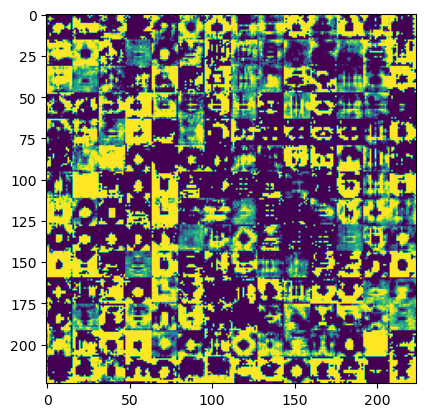

In [33]:
import matplotlib.pyplot as plt

plt.imshow(expl_out['explanation'][:,:,0])

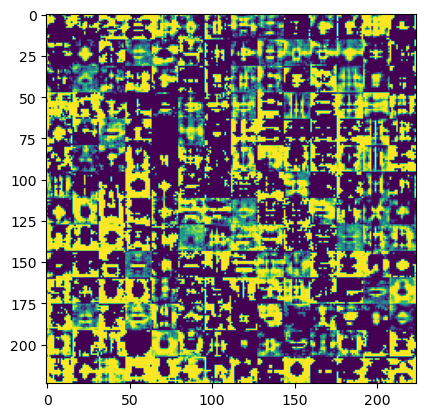

In [34]:
import matplotlib.pyplot as plt

plt.imshow(expl_out['explanation'][:,:,1])

In [ ]:
model

In [62]:
torch.hub.list("B-cos/B-cos-v2")

Using cache found in /home/runai-home/.cache/torch/hub/B-cos_B-cos-v2_main


['convnext_base',
 'convnext_base_bnu',
 'convnext_tiny',
 'convnext_tiny_bnu',
 'densenet121',
 'densenet121_long',
 'densenet161',
 'densenet169',
 'densenet201',
 'resnet101',
 'resnet152',
 'resnet152_long',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet50_long',
 'resnext50_32x4d',
 'simple_vit_b_patch16_224',
 'simple_vit_l_patch16_224',
 'simple_vit_s_patch16_224',
 'simple_vit_ti_patch16_224',
 'standard_simple_vit_b_patch16_224',
 'standard_simple_vit_l_patch16_224',
 'standard_simple_vit_s_patch16_224',
 'standard_simple_vit_ti_patch16_224',
 'standard_vitc_b_patch1_14',
 'standard_vitc_l_patch1_14',
 'standard_vitc_s_patch1_14',
 'standard_vitc_ti_patch1_14',
 'vgg11_bnu',
 'vitc_b_patch1_14',
 'vitc_l_patch1_14',
 'vitc_s_patch1_14',
 'vitc_ti_patch1_14']

In [69]:
model = torch.hub.load("B-cos/B-cos-v2", "simple_vit_b_patch16_224", pretrained=True).to(device)

Using cache found in /home/runai-home/.cache/torch/hub/B-cos_B-cos-v2_main


In [70]:
expl_out = model.explain(inputs)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (196x768 and 1536x768)

## XDNN

In [120]:
from exlib.modules.xdnn import XDNN

model = XDNN('xfixup_resnet50', 
             '/shared_data0/weiqiuy/github/fast-axiomatic-attribution/pt_models/xfixup_resnet50_model_best.pth.tar').to(device)
model = model.to(device)
model.eval();

In [121]:
outputs = model(inputs)

In [114]:
outputs.logits.shape, outputs.attributions.shape

(torch.Size([16, 1000]), torch.Size([16, 3, 224, 224]))

In [115]:
preds = outputs.logits.argmax(-1)
preds, labels

(tensor([  1,   9,   2,   8, 983,   3, 395, 103,   2,   3,   4,   3,   3,   5,
           4,   4], device='cuda:0'),
 tensor([1, 9, 2, 8, 3, 3, 5, 6, 2, 3, 3, 3, 5, 5, 2, 2], device='cuda:0'))

In [117]:
(preds == labels).sum() / len(preds)

tensor(0.5625, device='cuda:0')

In [118]:
logits = original_model(inputs)
preds = logits.argmax(-1)
preds, labels

AttributeError: 'Tensor' object has no attribute 'logits'

In [122]:
from exlib.evaluators.common import convert_idx_masks_to_bool

attrs = outputs.attributions
k = 0.2

masks_all = []
for idx in range(len(inputs)):
    # Create a mask of size (28, 28) with values from 1 to 28*28
    cell_size = 14
    image_size = 224
    mask = torch.arange(1, cell_size*cell_size + 1, dtype=torch.int).reshape(cell_size, cell_size)

    # Resize the mask to (224, 224) without using intermediate floating point numbers
    # This can be achieved by repeating each value in both dimensions to scale up the mask
    scale_factor = image_size // cell_size  # Calculate scale factor
    resized_mask = mask.repeat_interleave(scale_factor, dim=0).repeat_interleave(scale_factor, dim=1)

    masks = convert_idx_masks_to_bool(resized_mask[None]).to(device)
    mask_weights = (masks.to(device) * attrs[idx][0:1].to(device)).sum(-1).sum(-1).to(device)
    sort_idxs = torch.argsort(mask_weights).flip(-1)
    masks = masks[sort_idxs]
    mask_weights = mask_weights[sort_idxs]

    topk = int(masks.shape[0] * k)
    masks_use = masks[:topk]
    mask = masks_use.sum(0)

    # metrics
    # entropy = get_entropy(mask[None], segs[idx])
    # entropies.append(entropy.item())
    # ratios_obj_coverage.extend(get_prob_obj_coverage(mask[None], segs[idx]).view(-1).cpu().numpy().tolist())
    # ratios_obj.extend(get_prob_obj(mask[None], segs[idx]).view(-1).cpu().numpy().tolist())

    masks_all.append(mask)

masks_all = torch.stack(masks_all, dim=0)

In [123]:
masks_all.shape

torch.Size([16, 224, 224])

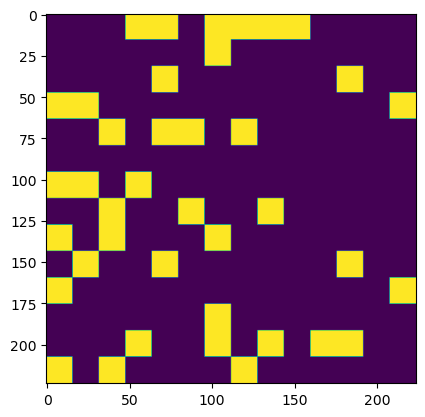

In [124]:
plt.imshow(masks_all[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


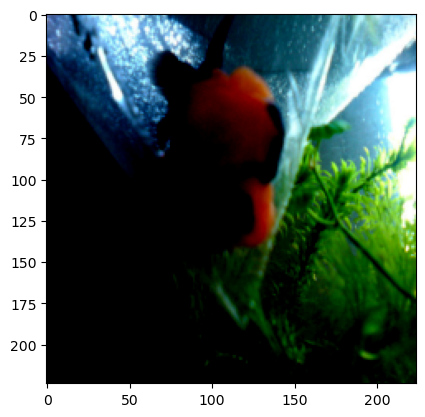

In [125]:
import matplotlib.pyplot as plt

plt.imshow(inputs[0].permute(1,2,0).cpu())

In [126]:
inputs.min(), inputs.max()

(tensor(-1., device='cuda:0'), tensor(1., device='cuda:0'))

In [136]:
# Get masked output
masked_inputs = masks_all[:,None] * inputs

# masked_preds = original_model((masked_inputs + 1)/2).argmax(-1)
masked_preds = original_model(masked_inputs).argmax(-1)

In [137]:
masked_preds, labels

(tensor([  1, 232,   2,   8, 983,   4,  65, 394,   4, 394,   4, 405, 980,   5,
           4, 673], device='cuda:0'),
 tensor([1, 9, 2, 8, 3, 3, 5, 6, 2, 3, 3, 3, 5, 5, 2, 2], device='cuda:0'))

In [138]:
(masked_preds == labels).sum()

tensor(4, device='cuda:0')

In [95]:
# Get masked output
masked_inputs = masks_all[:,None] * inputs
# if explainer_name in ['xdnn']:
# masked_inputs_norm = model.normalize(masked_inputs)
masked_inputs_norm = model.normalize((masked_inputs + 1)/2)

outputs = model.model(masked_inputs_norm)

In [96]:
pred = outputs.argmax(-1)
pred

tensor([750], device='cuda:0')

In [90]:
backbone_config.id2label[pred.item()]

'quilt, comforter, comfort, puff'

### Test

In [14]:
import sys
root_dir = '/shared_data0/weiqiuy/github/fast-axiomatic-attribution'
sys.path.append(root_dir)

import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

from imagenet.models import AlexNet, XAlexNet, vgg16, xvgg16, fixup_resnet50, xfixup_resnet50
from collections import OrderedDict

from captum.attr import Saliency, InputXGradient, IntegratedGradients

import argparse
import os
import time
from imagenet.utils import AttributionPriorExplainer
import torchvision.datasets as datasets

import argparse
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from imagenet.utils.visualization import visualize_attrs, show_img, pil_img

In [15]:
torch.manual_seed(6)
np.random.seed(4)
device = "cuda:0"
batch_size = 1

model_dict = '/shared_data0/weiqiuy/github/fast-axiomatic-attribution/pt_models/' # set this to the dictionary containing your X-DNN
checkpoint = torch.load(model_dict + 'xfixup_resnet50_model_best.pth.tar', 
                        map_location=device)
model = xfixup_resnet50().to(device)
# load model and remove preceding "module." because it was stored as DataParallel
state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k[:7] == 'module.':
        name = k[7:]  # remove `module.`
    else:
        name = k
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [16]:
# prepare data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
unnormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])

In [17]:
model.eval()
images = normalize(inputs).detach().expand(2,3,224,224)
target = labels.expand(2)


images = images.to(device)
images.requires_grad = True # make sure this is set to True
target = target.to(device)

# compute output
outputs = model(images)

# compute attribution
target_outputs = torch.gather(outputs, 1, target.unsqueeze(-1))
gradients = torch.autograd.grad(torch.unbind(target_outputs), images, create_graph=False)[0]
attributions = gradients * images



# visualize
image = (unnormalize(images[0]).permute(1,2,0).detach().cpu().numpy() + 1)/2
attribution = attributions[0].detach().permute(1,2,0).cpu().numpy()

plt.imshow(image)
plt.imshow(attribution.mean(-1), alpha=0.5)
# #show_pil_image(pil_image(image))
# show_img(pil_img(image), out_dir='.', name='out.png')
# visualize_attrs(image, attribution)

NameError: name 'plt' is not defined

In [19]:
model

XFixupResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): XFixupBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (downsample): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): XFixupBottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): XFixupBottleneck(
      (conv1): Con

In [18]:
outputs.shape

torch.Size([2, 1000])

In [21]:
attributions.shape

torch.Size([2, 3, 224, 224])

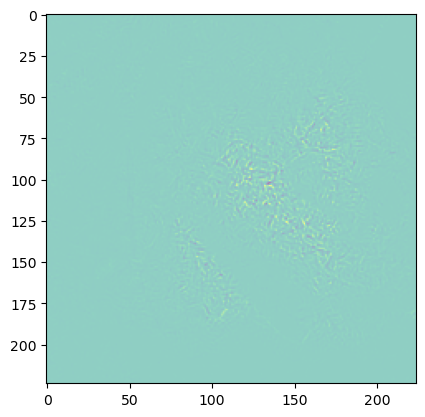

In [94]:
plt.imshow(attribution.mean(-1), alpha=0.5)

In [92]:
attribution.shape

(224, 224, 3)

## BagNet

In [34]:
from exlib.modules.bagnet import BagNet

model = BagNet().to(device)
model.eval();

In [50]:
sample = inputs.clone()
sample -= torch.tensor([0.485, 0.456, 0.406])[:, None, None].to(device)
sample /= torch.tensor([0.229, 0.224, 0.225])[:, None, None].to(device)

In [60]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
sample = normalize(inputs)

In [65]:
# outputs = model((inputs + 1)/2)
# outputs = model(sample)
outputs = model(inputs)
# outputs = model(normalize(inputs))

In [66]:
sample.mean(), sample.max()

(tensor(-1.9504, device='cuda:0'), tensor(2.3235, device='cuda:0'))

In [67]:
outputs.logits.shape, outputs.attributions.shape

(torch.Size([1, 1000]), torch.Size([1, 1, 224, 224]))

In [68]:
preds = outputs.logits.argmax(-1)
preds

tensor([319], device='cuda:0')

In [69]:
backbone_config.id2label[preds.item()]

"dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk"

In [42]:
import matplotlib.pyplot as plt


plt.imshow(outputs.attributions[0][0])

IndexError: index 1 is out of bounds for dimension 0 with size 1

### Test

In [13]:
import bagnets.pytorchnet
pytorch_model = bagnets.pytorchnet.bagnet33(pretrained=True)

In [14]:
pytorch_model = pytorch_model.to(device)
pytorch_model.eval();

In [15]:
outputs = pytorch_model(inputs)

/opt/conda/envs/rapids/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [16]:
outputs.shape

torch.Size([16, 1000])

In [56]:
# from bagnets.utils import plot_heatmap, generate_heatmap_pytorch
def generate_heatmap_pytorch(model, image, target=None, patchsize=None):
    """
    Generates high-resolution heatmap for a BagNet by decomposing the
    image into all possible patches and by computing the logits for
    each patch.
    
    Parameters
    ----------
    model : Pytorch Model
        This should be one of the BagNets.
    image : Numpy array of shape [1, 3, X, X]
        The image for which we want to compute the heatmap.
    target : int
        Class for which the heatmap is computed.
    patchsize : int
        The size of the receptive field of the given BagNet.
    
    """
    import torch
    
    with torch.no_grad():
        # pad with zeros
        _, c, x, y = image.shape
        padded_image = np.zeros((c, x + patchsize - 1, y + patchsize - 1))
        padded_image[:, (patchsize-1)//2:(patchsize-1)//2 + x, (patchsize-1)//2:(patchsize-1)//2 + y] = image[0]
        image = padded_image[None].astype(np.float32)
        
        # turn to torch tensor
        input = torch.from_numpy(image).cuda()
        
        # extract patches
        patches = input.permute(0, 2, 3, 1)
        patches = patches.unfold(1, patchsize, 1).unfold(2, patchsize, 1)
        num_rows = patches.shape[1]
        num_cols = patches.shape[2]
        patches = patches.contiguous().view((-1, 3, patchsize, patchsize))

        # compute logits for each patch
        logits_list = []
        import pdb; pdb.set_trace()
        for batch_patches in torch.split(patches, 1000):
            logits = model(batch_patches)
            if target is not None:
                logits = logits[:, target][:, 0]
            logits_list.append(logits.data) #.cpu().numpy().copy())

        # import pdb; pdb.set_trace()
        # logits = np.hstack(logits_list)
        logits = torch.cat(logits_list)
        print('logits', logits.shape)
        return logits.reshape((224, 224, 1000))

In [ ]:
# heatmap = generate_heatmap_pytorch(pytorch_model, inputs.cpu()[0:1], labels.cpu()[0:1], 33)
heatmap = generate_heatmap_pytorch(pytorch_model, inputs.cpu()[0:1], None, 33)

> /tmp/ipykernel_4189/2192056708.py(42)generate_heatmap_pytorch()
     40         logits_list = []
     41         import pdb; pdb.set_trace()
---> 42         for batch_patches in torch.split(patches, 1000):
     43             logits = model(batch_patches)
     44             if target is not None:



ipdb>  patches.shape


torch.Size([50176, 3, 33, 33])


ipdb>  patches[0]


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1922, 0.1529, 0.1373],
         [0.0000, 0.0000, 0.0000,  ..., 0.1608, 0.0980, 0.1059],
         [0.0000, 0.0000, 0.0000,  ..., 0.2235, 0.1216, 0.0980]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3255, 0.3255, 0.3490],
         [0.0000, 0.0000, 0.0000,  ..., 0.3647, 0.3255, 0.3176],
         [0.0000, 0.0000, 0.0000,  ..., 0.3961, 0.3490, 0.3255]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

ipdb>  patches[1]


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1529, 0.1373, 0.1294],
         [0.0000, 0.0000, 0.0000,  ..., 0.0980, 0.1059, 0.0824],
         [0.0000, 0.0000, 0.0000,  ..., 0.1216, 0.0980, 0.0980]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.3255, 0.3490, 0.3804],
         [0.0000, 0.0000, 0.0000,  ..., 0.3255, 0.3176, 0.3569],
         [0.0000, 0.0000, 0.0000,  ..., 0.3490, 0.3255, 0.3098]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

ipdb>  (patches[1] != 0).sum()


tensor(918, device='cuda:0')


ipdb>  918/33


27.818181818181817


ipdb>  918/224


4.098214285714286


ipdb>  import math; math.sqrt(918)


30.298514815086232


ipdb>  patches [-1]


tensor([[[-0.1137, -0.0980, -0.1059,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1294, -0.1373, -0.1059,  ...,  0.0000,  0.0000,  0.0000],
         [-0.1451, -0.1216, -0.1216,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.1843,  0.1529,  0.1686,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.1686,  0.1529,  0.1294,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.1529,  0.1373,  0.1373,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.5451, -0.5529, -0.5294,  ...,  0.0000,  0.0000,  0.0000],
         [-0.5608, -0.5686, -0.5137,  ...,  0

ipdb>  image.shape


(1, 3, 256, 256)


ipdb>  224+66


290


ipdb>  input.shape


torch.Size([1, 3, 256, 256])


ipdb>  input.permute(0, 2, 3, 1).shape


torch.Size([1, 256, 256, 3])


ipdb>  input.permute(0, 2, 3, 1).unfold(1, patchsize, 1).unfold(2, patchsize, 1).shape


torch.Size([1, 224, 224, 3, 33, 33])


In [47]:
outputs[0].softmax(-1)

tensor([5.1732e-05, 2.2782e-01, 2.0875e-04, 1.7846e-04, 1.8964e-04, 2.4739e-05,
        3.8269e-04, 3.9030e-04, 1.7106e-04, 1.2579e-05, 2.3121e-03, 8.4382e-04,
        1.7459e-03, 5.5922e-04, 4.1918e-04, 3.8215e-02, 8.7780e-04, 3.6663e-04,
        6.1399e-05, 1.7831e-03, 1.9424e-05, 1.5331e-04, 4.0978e-05, 3.7490e-05,
        2.3804e-05, 2.3431e-05, 5.4226e-05, 2.0454e-04, 2.2602e-05, 1.5024e-03,
        3.8771e-05, 3.5947e-04, 1.3644e-05, 7.0892e-04, 1.4807e-04, 5.0190e-05,
        3.7740e-04, 1.1204e-04, 3.2925e-05, 2.4190e-04, 2.0014e-04, 2.0475e-05,
        5.4665e-05, 1.3282e-04, 2.9992e-05, 4.5252e-05, 3.8711e-04, 3.8017e-05,
        3.3386e-05, 1.0467e-05, 4.9550e-05, 3.7886e-05, 1.4306e-04, 2.9838e-04,
        2.0858e-05, 3.2991e-04, 3.2697e-04, 3.9936e-05, 8.5511e-05, 1.0978e-04,
        1.0543e-04, 3.3366e-04, 2.9630e-05, 6.6908e-05, 9.2542e-05, 4.5136e-05,
        4.0622e-06, 4.3329e-05, 1.6215e-06, 9.1253e-05, 8.0257e-04, 5.3952e-04,
        1.4730e-03, 2.7372e-04, 9.5298e-

In [53]:
heatmap.mean(0).mean(0).softmax(-1)

tensor([1.1698e-03, 1.2960e-01, 1.6529e-04, 5.6378e-04, 3.1963e-04, 1.9872e-03,
        4.2867e-04, 1.4229e-04, 1.4892e-04, 1.0162e-05, 6.5785e-03, 4.6420e-04,
        4.7100e-04, 2.5779e-04, 6.0908e-04, 5.5173e-03, 7.4292e-04, 2.2726e-04,
        5.5280e-05, 6.2370e-04, 6.3276e-05, 3.3243e-04, 2.9605e-05, 4.9869e-05,
        1.6642e-05, 7.0916e-05, 8.0669e-03, 5.8579e-04, 5.9781e-05, 2.9571e-02,
        1.0789e-04, 3.4747e-04, 1.4897e-03, 9.9026e-04, 3.9310e-04, 4.6119e-04,
        2.5061e-03, 1.1605e-04, 2.1279e-03, 2.6176e-04, 4.2195e-04, 5.6516e-04,
        2.5149e-04, 1.4624e-03, 1.5959e-04, 8.4865e-05, 2.7136e-04, 7.8186e-04,
        3.9859e-05, 4.8184e-05, 3.4481e-05, 3.0581e-05, 5.6787e-04, 2.0620e-04,
        8.6004e-05, 4.5838e-05, 1.0040e-04, 2.3154e-05, 3.6809e-04, 2.7135e-04,
        1.0095e-04, 7.0349e-05, 9.6349e-05, 3.3938e-04, 3.7850e-04, 9.8473e-05,
        8.5514e-05, 5.0873e-05, 3.0374e-05, 1.3929e-04, 6.7691e-04, 3.6247e-04,
        1.8698e-03, 3.4304e-03, 8.7587e-

In [26]:
labels[0:1]

tensor([1], device='cuda:0')

In [27]:
heatmap.shape

(224, 224)

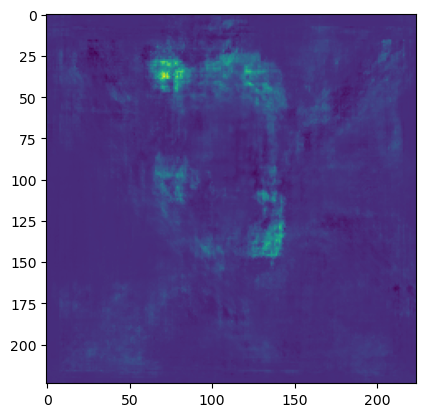

In [28]:
import matplotlib.pyplot as plt

plt.imshow(heatmap)

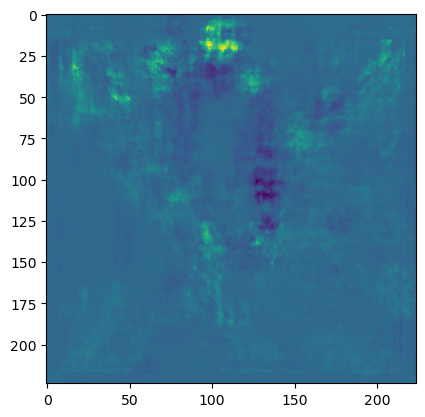

In [29]:
heatmap = generate_heatmap_pytorch(pytorch_model, inputs.cpu()[0:1], torch.tensor([4]), 33)
import matplotlib.pyplot as plt

plt.imshow(heatmap)

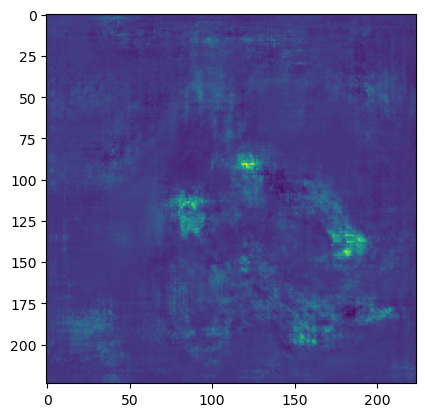

In [30]:
heatmap = generate_heatmap_pytorch(pytorch_model, inputs.cpu(), 
                                   labels, 33)
plt.imshow(heatmap)

## Archipelago

In [11]:
from exlib.explainers.archipelago import ArchipelagoImageCls
import time

explainer = ArchipelagoImageCls(original_model)
explainer = explainer.to(device)
multi_labels = torch.tensor([[0, 1, 2, 3, 4]]).to(device)
start = time.time()
arc_expln_multi = explainer(inputs, multi_labels)
print(time.time() - start)

8.825692653656006


In [13]:
arc_expln_multi.explainer_output['masks'][0][0].shape, arc_expln_multi.explainer_output['masks'][0][1].shape

(torch.Size([42, 224, 224]), torch.Size([42, 224, 224]))

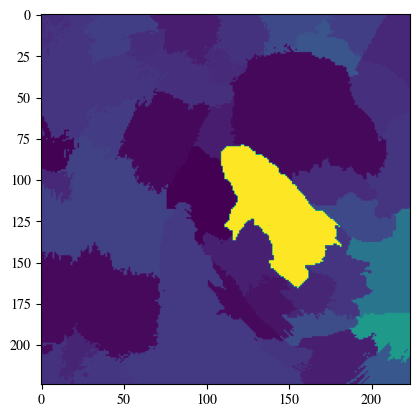

In [14]:
import matplotlib.pyplot as plt

plt.imshow(arc_expln_multi.attributions[0][0].cpu().numpy())

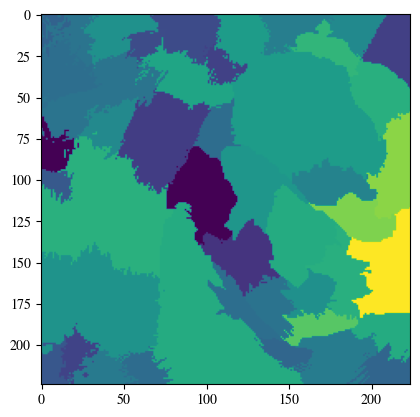

In [15]:
import matplotlib.pyplot as plt

plt.imshow(arc_expln_multi.attributions[0][1].cpu().numpy())

In [12]:
from exlib.explainers.archipelago import ArchipelagoImageCls

explainer = ArchipelagoImageCls(original_model)
explainer = explainer.to(device)
start = time.time()
arc_expln = explainer(inputs, labels)
print(time.time() - start)

7.5107502937316895


In [12]:
arc_expln.attributions.shape, arc_expln.explainer_output['expln_flat_masks'].shape

(torch.Size([1, 2, 224, 224]), torch.Size([1, 2, 224, 224]))

torch.Size([1, 1, 224, 224])
torch.Size([1, 224, 224])


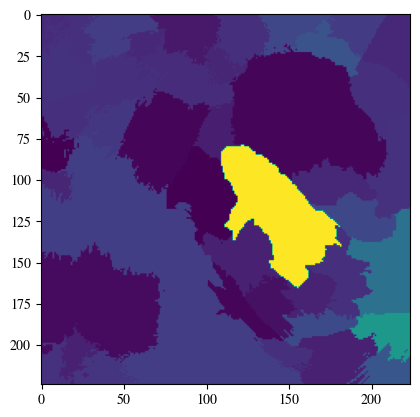

In [16]:
import matplotlib.pyplot as plt

plt.imshow(arc_expln.attributions[0][0].cpu().numpy())

In [20]:
len(arc_expln.explainer_output['masks']), arc_expln.explainer_output['masks'][0].shape

(1, torch.Size([42, 224, 224]))

In [21]:
len(arc_expln.explainer_output['mask_weights']), arc_expln.explainer_output['mask_weights'][0].shape

(1, torch.Size([42]))

In [24]:
arc_expln.explainer_output['mask_weights'][0]

tensor([ 9.2433,  4.5881,  2.9611,  1.9041,  1.7883,  1.4909,  1.4238,  1.3721,
         1.0981,  1.0661,  1.0403,  1.0326,  0.8619,  0.7711,  0.7031,  0.6753,
         0.6621,  0.6468,  0.5959,  0.5814,  0.5782,  0.5778,  0.5180,  0.4279,
         0.4019,  0.3995,  0.3987,  0.3157,  0.3079,  0.1875,  0.1569,  0.1467,
         0.1436,  0.0616, -0.0814, -0.3088, -0.4586, -0.5909, -0.6269, -0.6304,
        -0.7434, -0.7597], device='cuda:0')

In [27]:
from tqdm.auto import tqdm

grouped_attrs = []
for i in tqdm(range(10)):
    arc_expln = explainer(inputs, torch.tensor([i]))
    grouped_attrs.append(arc_expln.explainer_output['mask_weights'][0])

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
grouped_attrs_aggr = torch.tensor([ga.sum() for ga in grouped_attrs])
grouped_attrs_aggr

tensor([34.9282, 36.1642, 41.2544, 45.9257, 56.2730, 26.2573, 69.8167, 26.1337,
        41.6529, 29.9351])

In [29]:
torch.argmax(grouped_attrs_aggr)

tensor(6)

In [30]:
labels

tensor([0], device='cuda:0')

## Lime

In [12]:
from exlib.explainers.lime import LimeImageCls
from exlib.explainers.common import patch_segmenter

eik = {
    "segmentation_fn": patch_segmenter,
    "top_labels": 1000, 
    "hide_color": 0, 
    "num_samples": 1000
}
gimk = {
    "positive_only": False
}
lime_explainer = LimeImageCls(original_model, 
                      explain_instance_kwargs=eik, 
                      get_image_and_mask_kwargs=gimk)

lime_expln = lime_explainer(inputs, labels)

  0%|          | 0/1000 [00:00<?, ?it/s]

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


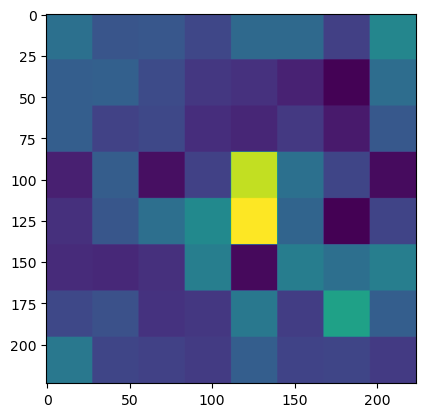

In [13]:
import matplotlib.pyplot as plt

plt.imshow(lime_expln.attributions[0][0].cpu().numpy())

In [20]:
lime_expln.explainer_output[0].segments.shape

(224, 224)

In [26]:
grouped_attrs_lime = []
for i in tqdm(range(10)):
    grouped_attrs_lime.append([v for k, v in lime_expln.explainer_output[0].local_exp[i]])

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
grouped_attrs_lime_aggr = torch.tensor([sum(ga) for ga in grouped_attrs_lime])
grouped_attrs_lime_aggr

tensor([10.1181,  3.6614,  4.1204,  5.9402,  5.7994,  3.1241,  2.3985, -1.3396,
        -3.1976, -2.7439], dtype=torch.float64)

In [30]:
torch.argmax(grouped_attrs_lime_aggr)

tensor(0)

## SHAP

In [12]:
from exlib.explainers import ShapImageCls

shap_explainer = ShapImageCls(original_model).to(device)

multi_labels = torch.tensor([[0, 1, 2, 3, 4]]).to(device)
import time
start = time.time()
shap_expln = shap_explainer(inputs, multi_labels)
print(time.time() - start)

device cuda:0
2.1597750186920166


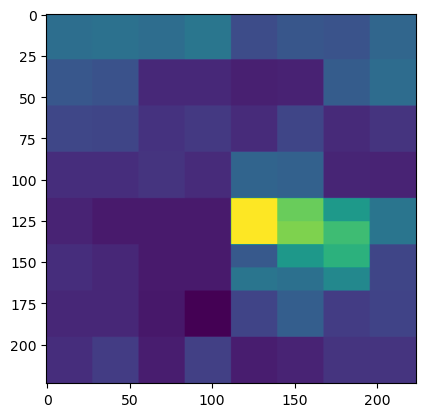

In [14]:
import matplotlib.pyplot as plt

plt.imshow(shap_expln.attributions[0][0].cpu().numpy())

In [14]:
shap_expln.attributions[0][0].shape

torch.Size([224, 224])

In [13]:
shap_expln.explainer_output[0].values.shape

(1, 224, 224, 3, 2)

In [19]:
shap_expln.explainer_output[0].values[0,:,:,:,1].min(), shap_expln.explainer_output[0].values[0,:,:,:,1].max()

(-4.969735708654712e-05, 0.0003138270844736289)

In [21]:
shap_expln.explainer_output[0].values[0,:,:,:,0].min(), shap_expln.explainer_output[0].values[0,:,:,:,0].max()

(-5.7757030665671746e-05, 0.0005708316918021008)

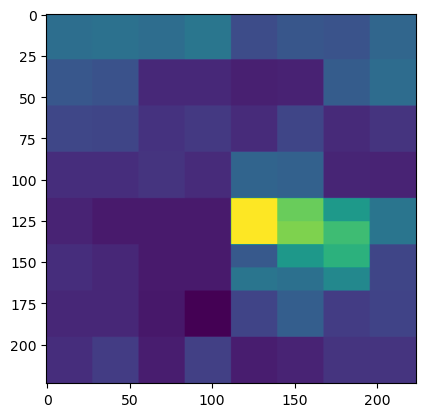

In [15]:
import matplotlib.pyplot as plt

plt.imshow(shap_expln.explainer_output[0].values[0,:,:,0,0])

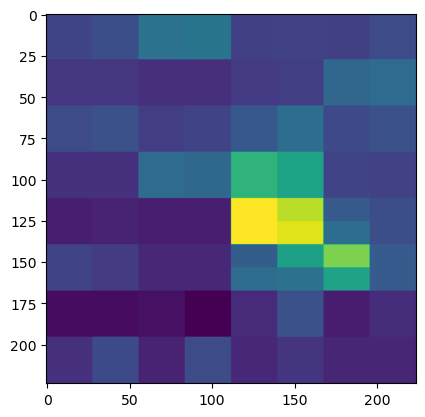

In [16]:
import matplotlib.pyplot as plt

plt.imshow(shap_expln.explainer_output[0].values[0,:,:,0,1])

In [13]:
from exlib.explainers import ShapImageCls
import time
shap_explainer = ShapImageCls(original_model).to(device)

start = time.time()
shap_expln = shap_explainer(inputs, labels)
print(time.time() - start)

device cuda:0
2.1135990619659424


In [12]:
labels

tensor([0], device='cuda:0')

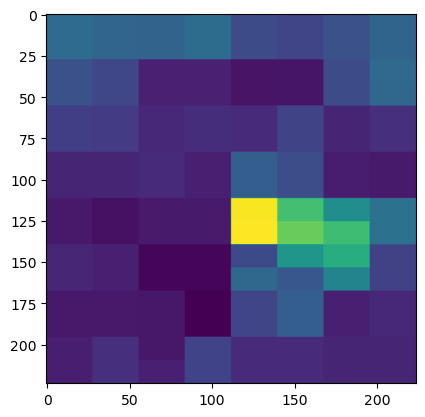

In [13]:
import matplotlib.pyplot as plt

plt.imshow(shap_expln.attributions[0][0].cpu().numpy())

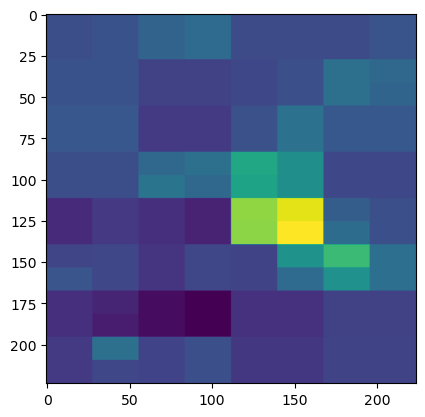

In [31]:
shap_expln = shap_explainer(inputs, torch.tensor([1]))
plt.imshow(shap_expln.attributions[0][0].cpu().numpy())

In [37]:
grouped_attrs_shap = []
for i in tqdm(range(10)):
    shap_expln = shap_explainer(inputs, torch.tensor([i]))
    grouped_attrs_shap.append(shap_expln.attributions.view(-1))
grouped_attrs_shap_aggr = torch.stack(grouped_attrs_shap).sum(-1)
grouped_attrs_shap_aggr

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([12.4653,  5.4695,  4.2645,  5.7603,  4.9919,  2.2466,  6.2427,  1.2154,
         1.2253,  0.7736], dtype=torch.float64)

In [38]:
torch.argmax(grouped_attrs_shap_aggr)

tensor(0)

## RISE

In [12]:
from exlib.explainers import RiseImageCls

rise_explainer = RiseImageCls(original_model).to(device)

rise_expln = rise_explainer(inputs, labels)

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


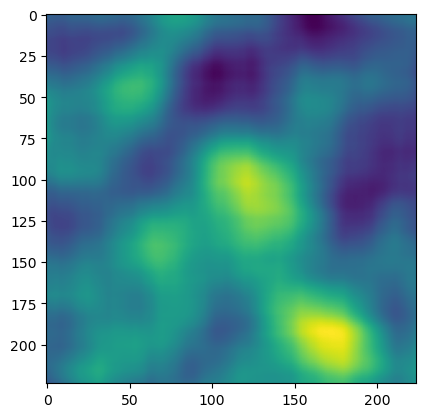

In [13]:
import matplotlib.pyplot as plt

plt.imshow(rise_expln.attributions[0][0].cpu().numpy())

In [14]:
rise_expln.explainer_output.shape

torch.Size([1, 10, 224, 224])

In [17]:
grouped_attrs_rise_aggr = rise_expln.explainer_output[0].sum(-1).sum(-1)
grouped_attrs_rise_aggr, torch.argmax(grouped_attrs_rise_aggr)

(tensor([5.3816e+08, 2.5299e+08, 1.7383e+08, 2.1951e+08, 2.4043e+08, 1.9186e+08,
         2.7809e+08, 2.8644e+07, 1.6272e+07, 4.9189e+06], device='cuda:0'),
 tensor(0, device='cuda:0'))

## IntGrad

In [18]:
from exlib.explainers import IntGradImageCls

intgrad_explainer = IntGradImageCls(original_model).to(device)

intgrad_expln = intgrad_explainer(inputs, labels)

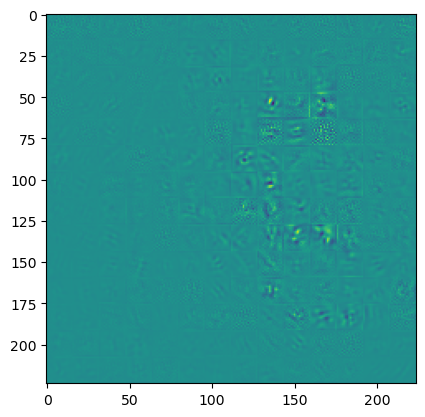

In [24]:
import matplotlib.pyplot as plt

plt.imshow(intgrad_expln.attributions[0].mean(0).cpu().numpy())

In [26]:
grouped_attrs_intgrad = []
for i in tqdm(range(10)):
    intgrad_expln = intgrad_explainer(inputs, torch.tensor([i]))
    grouped_attrs_intgrad.append(intgrad_expln.attributions.sum(1).view(-1))
grouped_attrs_intgrad_aggr = torch.stack(grouped_attrs_intgrad).sum(-1)
grouped_attrs_intgrad_aggr, torch.argmax(grouped_attrs_intgrad_aggr)

  0%|          | 0/10 [00:00<?, ?it/s]

(tensor([-3.7287e+00, -2.9831e-01,  2.2829e-01,  2.0972e+00,  1.0890e+00,
          4.6852e-01,  3.5330e-01, -4.2825e-01, -6.4699e-01,  3.5429e-04],
        device='cuda:0'),
 tensor(3, device='cuda:0'))

## GradCAM

In [ ]:
from exlib.explainers import GradCAMImageCls

gradcam_explainer = GradCAMImageCls(original_model, [original_model.model.vit.encoder.layer[-1].layernorm_before]).to(device)

gradcam_expln = gradcam_explainer(inputs, labels)

> /shared_data0/weiqiuy/sop/lib/pytorch-grad-cam/pytorch_grad_cam/grad_cam.py(23)get_cam_weights()
     21                         grads):
     22         import pdb; pdb.set_trace()
---> 23         if len(grads.shape) == 4: # image
     24             return np.mean(grads, axis=(-1, -2))
     25         else: # len(grads.shape) == 3, text



ipdb>  grads.shape


(16, 768, 14, 14)


ipdb>  c


> /shared_data0/weiqiuy/sop/lib/pytorch-grad-cam/pytorch_grad_cam/utils/image.py(166)scale_cam_image()
    164         img = img / (1e-7 + np.max(img))
    165         import pdb; pdb.set_trace()
--> 166         if target_size is not None:
    167             img = cv2.resize(img, target_size)
    168         result.append(img)



ipdb>  img.shape


(14, 14)


ipdb>  target_size


(224, 224)
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> /shared_data0/weiqiuy/sop/lib/pytorch-grad-cam/pytorch_grad_cam/utils/image.py(166)scale_cam_image()
    164         img = img / (1e-7 + np.max(img))
    165         if target_size is not None:
--> 166             img = cv2.resize(img, target_size)
    167         result.append(img)
    168     result = np.float32(result)



In [13]:
gradcam_expln.attributions.shape

torch.Size([1, 1, 224, 224])

In [14]:
grouped_attrs_gradcam = []
for i in tqdm(range(10)):
    gradcam_expln = gradcam_explainer(inputs, torch.tensor([i]))
    grouped_attrs_gradcam.append(gradcam_expln.attributions.mean(1).view(-1))
grouped_attrs_gradcam_aggr = torch.stack(grouped_attrs_gradcam).sum(-1)
grouped_attrs_gradcam_aggr, torch.argmax(grouped_attrs_gradcam_aggr)

  0%|          | 0/10 [00:00<?, ?it/s]

(tensor([9275.5342, 8105.1675, 9275.5342, 8105.1689, 8105.1685, 8105.1646,
         8105.1709, 9275.5273, 9275.5244, 8104.9180]),
 tensor(0))

## FRESH

In [ ]:
with torch.no_grad():
    expln = model(inputs, return_tuple=True)

In [ ]:
expln.attributions.shape

In [ ]:
denormed_img = (inputs[0:1] + 1) / 2

## Aggregate Prediction Consistency

In [17]:
expln.masks.shape, expln.mask_weights.shape, expln.logits.shape, expln.logits_all.shape, expln.attributions_all.shape, expln.group_attributions.shape

(torch.Size([1, 392, 224, 224]),
 torch.Size([1, 392, 10]),
 torch.Size([1, 10]),
 torch.Size([1, 392, 10]),
 torch.Size([1, 10, 224, 224]),
 torch.Size([1, 392, 10]))

In [15]:
expln.group_attributions.sum(dim=-2) - expln.logits

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00, -9.5367e-07, -9.5367e-07,
          0.0000e+00,  0.0000e+00,  2.9802e-08,  3.7253e-09, -7.4506e-09]],
       device='cuda:0')

In [22]:
group_attributions.sum(dim=-2)

tensor([[11.8008,  5.9778,  8.9909,  9.7012,  9.2917,  4.5402,  6.5247,  0.3107,
         -0.0615,  0.0682]], device='cuda:0')

In [23]:
expln.logits

tensor([[11.8008,  5.9778,  8.9909,  9.7012,  9.2917,  4.5402,  6.5247,  0.3107,
         -0.0615,  0.0682]], device='cuda:0')

In [30]:
attrs = (expln.masks.bool().float().unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1)).sum(1)
attrs.shape

torch.Size([1, 10, 224, 224])

In [34]:
attrs[0][labels].cpu().numpy()[0]

array([[0.96653795, 0.96653795, 0.96653795, ..., 0.9840308 , 0.9840308 ,
        0.9840308 ],
       [0.96653795, 0.96653795, 0.96653795, ..., 0.9840308 , 0.9840308 ,
        0.9840308 ],
       [0.96653795, 0.96653795, 0.96653795, ..., 0.9840308 , 0.9840308 ,
        0.9840308 ],
       ...,
       [0.7248243 , 0.7248243 , 0.7248243 , ..., 0.93425035, 0.93425035,
        0.93425035],
       [0.7248243 , 0.7248243 , 0.7248243 , ..., 0.93425035, 0.93425035,
        0.93425035],
       [0.7248243 , 0.7248243 , 0.7248243 , ..., 0.93425035, 0.93425035,
        0.93425035]], dtype=float32)

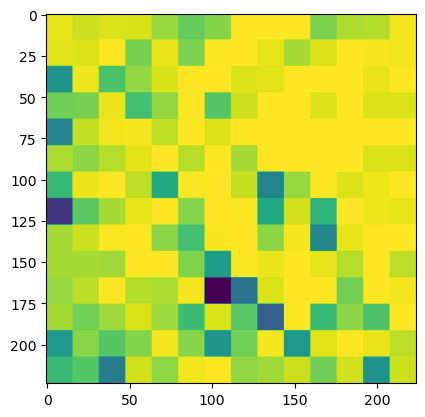

In [33]:
import matplotlib.pyplot as plt
plt.imshow(attrs[0][labels].cpu().numpy()[0])

In [35]:
attrs2 = (expln.masks.bool().float().unsqueeze(2) * expln.mask_weights.unsqueeze(-1).unsqueeze(-1) * expln.logits_all.unsqueeze(-1).unsqueeze(-1)).sum(1)
attrs2.shape

torch.Size([1, 10, 224, 224])

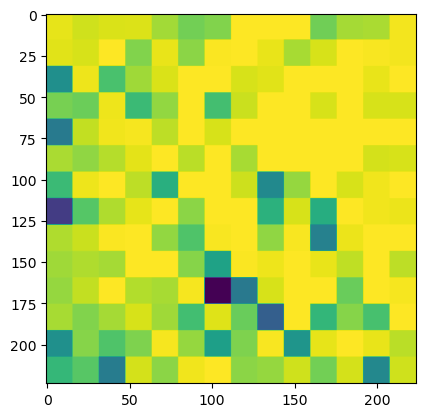

In [36]:
import matplotlib.pyplot as plt
plt.imshow(attrs2[0][labels].cpu().numpy()[0])

## Insertion Deletion

In [13]:
from exlib.evaluators.ins_del import InsertionCls, DeletionCls

 99%|█████████▉| 223/225 [08:37<00:04,  2.32s/it]


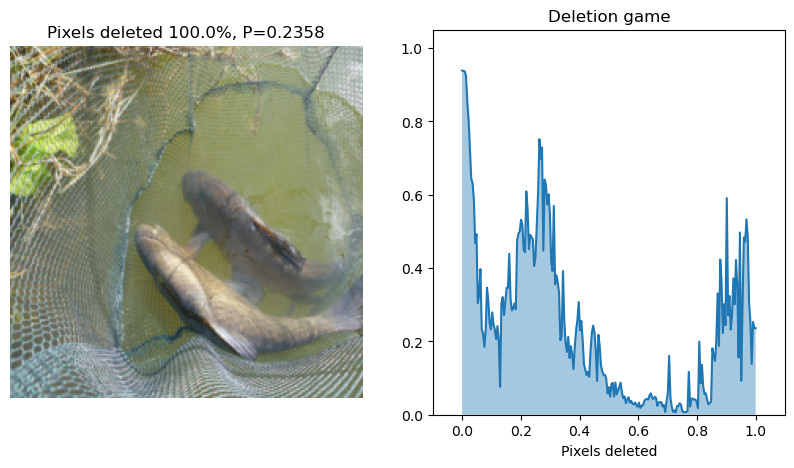

tensor([0.2419], device='cuda:0')


In [14]:
del_evaluator = DeletionCls(model)
with torch.no_grad():
    del_eval_output = del_evaluator(inputs, expln.attributions, return_dict=True)
del_scores = del_eval_output['scores']
del_evaluator.plot(denormed_img[0], del_scores[0])
print(del_eval_output['auc_score'])

 99%|█████████▉| 223/225 [08:56<00:04,  2.40s/it]


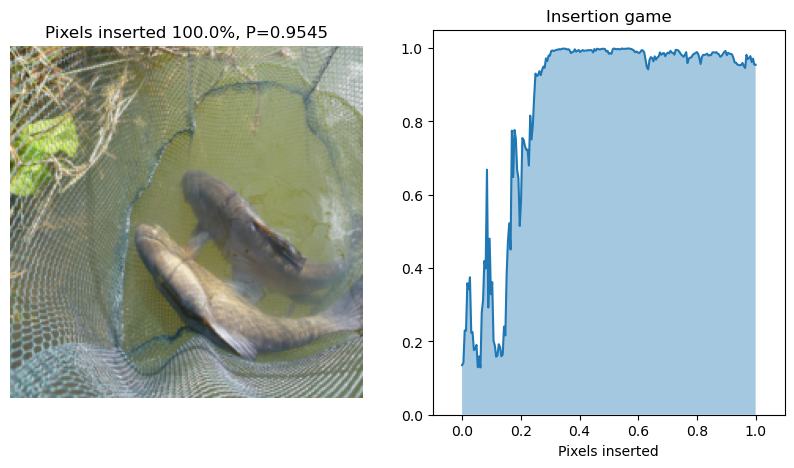

In [15]:
ins_evaluator = InsertionCls(model)
with torch.no_grad():
    ins_eval_output = ins_evaluator(inputs, expln.attributions, return_dict=True)
ins_evaluator.plot(denormed_img[0], ins_eval_output['scores'][0])

In [16]:
ins_eval_output['auc_score']

tensor([0.8429], device='cuda:0')

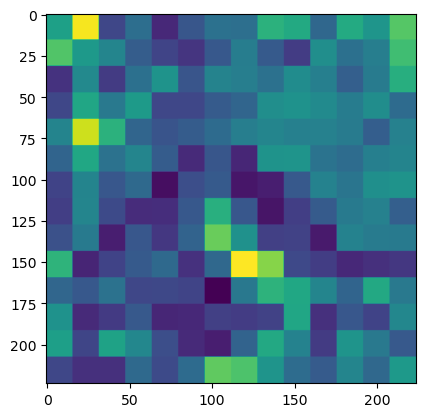

In [18]:
import matplotlib.pyplot as plt
plt.imshow(expln.attributions[0][0].cpu().numpy())

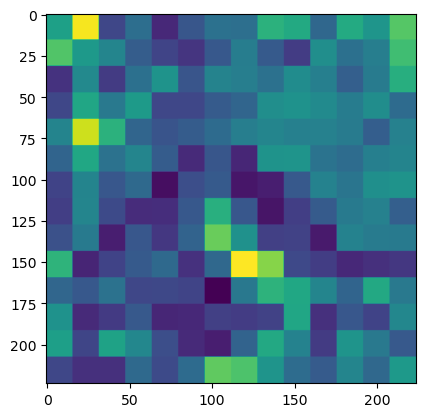

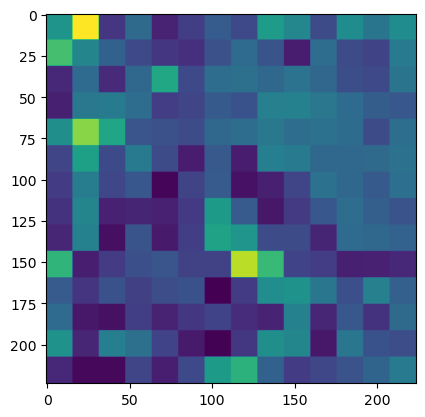

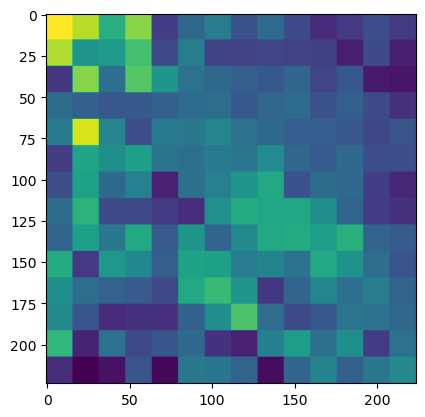

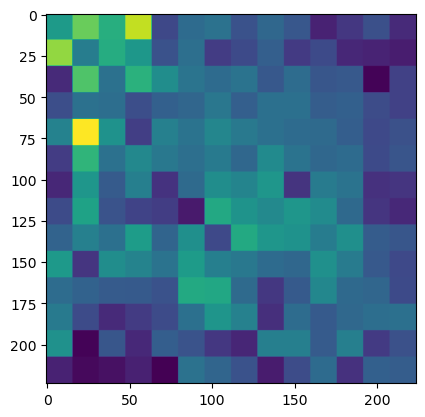

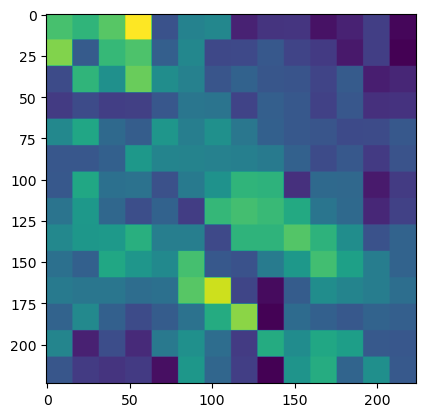

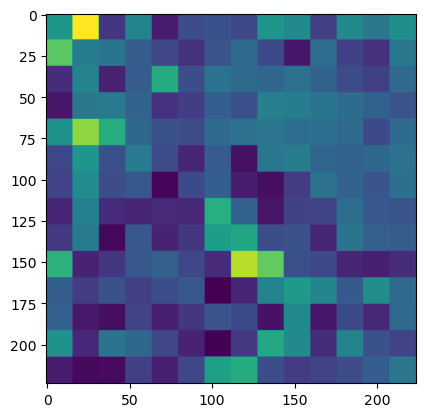

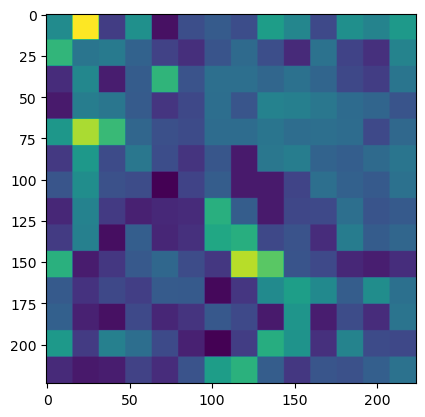

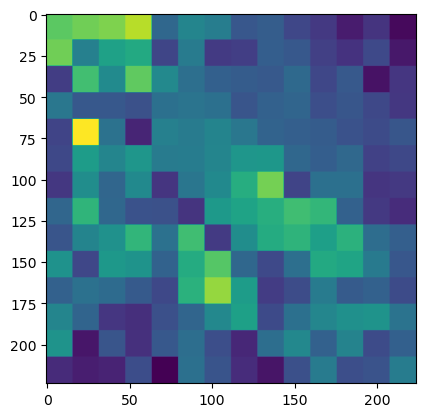

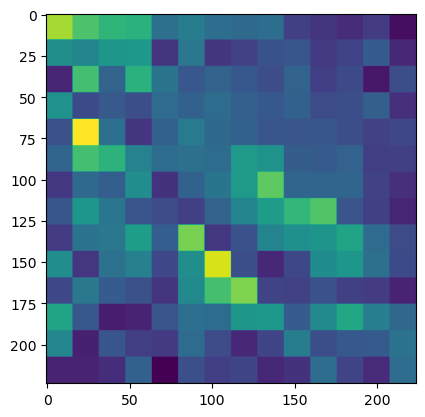

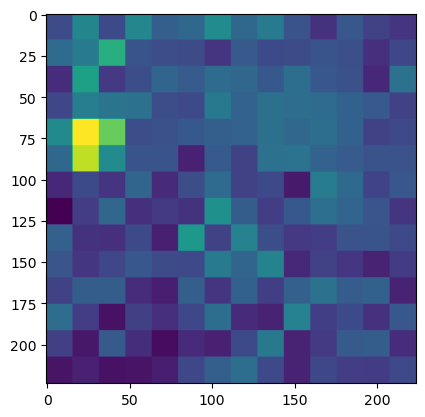

In [19]:
for i in range(expln.attributions_all.shape[1]):
    plt.figure()
    plt.imshow(expln.attributions_all[0][i].cpu().numpy())
    plt.show()

In [21]:
from exlib.evaluators.ins_del import GroupedInsertionCls, GroupedDeletionCls

In [22]:
gdel_evaluator = GroupedDeletionCls(model)
with torch.no_grad():
    gdel_score = gdel_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gdel_score)

tensor([0.3955], device='cuda:0')


In [23]:
with torch.no_grad():
    gdel_eval_output = gdel_evaluator(inputs, expln.attributions[0], expln.flat_masks, return_dict=True)

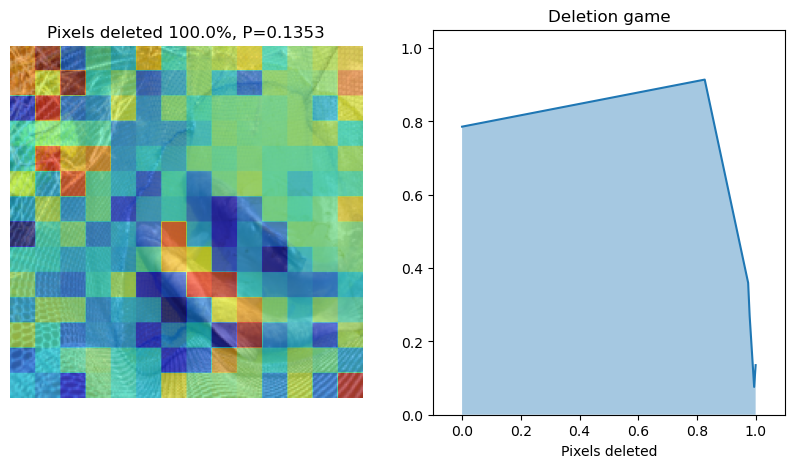

In [24]:
gdel_evaluator.plot(denormed_img[0], expln.attributions[0], gdel_eval_output['scores'][0], gdel_eval_output['step_sizes'][0])

In [17]:
gins_evaluator = GroupedInsertionCls(model)
with torch.no_grad():
    gins_score = gins_evaluator(inputs, expln.attributions, expln.flat_masks)
print(gins_score)

tensor([0.1230], device='cuda:0')


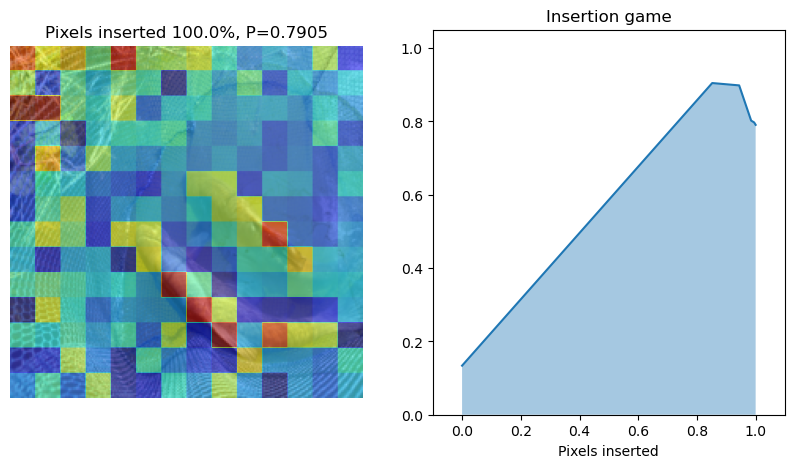

In [19]:
with torch.no_grad():
    gins_eval_output = gins_evaluator(inputs, expln.attributions, expln.flat_masks, return_dict=True)
gins_evaluator.plot(denormed_img[0], expln.attributions[0], gins_eval_output['scores'][0], gins_eval_output['step_sizes'][0])

In [20]:
gins_eval_output['scores']

[tensor([0.1338, 0.9046, 0.8982, 0.8021, 0.7971, 0.7905], device='cuda:0')]

## Baselines

### Archipelago

In [10]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
import pickle

sys.path.append("../lib/archipelago/src")
from explainer import Archipelago
from application_utils.image_utils import *
from application_utils.utils_torch import ModelWrapperTorch

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [11]:
explanation_outline_thickness = 1

In [21]:
from collections import namedtuple

WrappedBackboneOutput = namedtuple("WrappedBackboneOutput", 
                                  ["logits",
                                   "pooler_output"])


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [22]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)
wrapped_backbone_model_raw = wrapped_backbone_model_raw.to(device)
model_wrapper = ModelWrapperTorch(wrapped_backbone_model_raw, device)

image (224, 224, 3) label tensor(0, device='cuda:0')
classification: tench, Tinca tinca


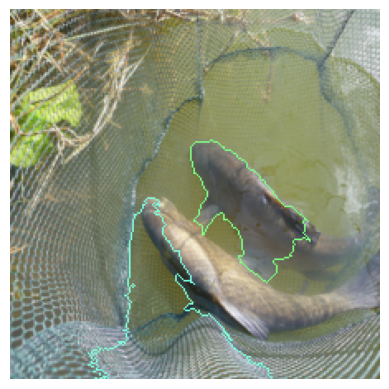

In [31]:
top_k = 5

# results = []
# for index in tqdm(indexes[:12+len(skip_imgs)]):    
# if index in skip_imgs: continue

# image_path = test_data[index]
# img_filename = image_path.split("/")[-1]
# image, labels = get_image_and_labels(image_path, device)

image = inputs[0].cpu().permute(1,2,0).numpy()
label = labels[0]
print('image', image.shape, 'label', label)

predictions = model_wrapper(np.expand_dims(image,0))
class_idx = predictions[0].argsort()[::-1][0]
print("classification:",backbone_config.id2label[class_idx])

baseline = np.zeros_like(image)
segments = quickshift(image, kernel_size=3, max_dist=300, ratio=0.2)

xf = ImageXformer(image, baseline, segments)
apgo = Archipelago(model_wrapper, data_xformer=xf, output_indices=class_idx, batch_size=20)
explanation = apgo.explain(top_k=top_k)
exp, num_pos_interactions = overlay_explanation(explanation, image, segments, outline_thickness = explanation_outline_thickness)


plt.imshow(exp/2+0.5)
plt.axis("off")
plt.show()
    
    # results.append( {"image":exp, "prediction": labels[class_idx]} )
    
#     with open('results/exp_figs_4-21_k5_nohuman_thin.pickle', 'wb') as handle:
#         pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [32]:
explanation

{(0,): 0.42529047,
 (1,): 1.3719839,
 (2,): 1.0474758,
 (3,): -0.085602075,
 (4,): 0.58869743,
 (5,): 1.0348862,
 (6,): 0.40848237,
 (7,): 0.38664788,
 (8,): 1.7787969,
 (9,): 0.29978138,
 (10,): 0.5662061,
 (11,): 0.51545054,
 (12,): 0.7138524,
 (13,): 0.8627353,
 (14,): 0.5923417,
 (15,): -0.62160134,
 (16,): 0.07945675,
 (17,): 0.68777966,
 (18,): -0.5787919,
 (19,): -0.773232,
 (20,): 0.3929776,
 (21,): 0.3048277,
 (22,): -0.7482835,
 (23, 27): 9.251493,
 (24,): 1.4461168,
 (25,): 0.17124562,
 (26,): 1.110541,
 (28, 39, 40, 43, 46): 1.0905472,
 (29,): 0.5786019,
 (30,): 2.946011,
 (31,): -0.43382567,
 (32,): 0.18923682,
 (33,): -0.28266913,
 (34,): -0.6338183,
 (35,): 4.5963902,
 (36,): 1.4934913,
 (37,): 0.16700691,
 (38,): 0.13798222,
 (41,): 0.64322615,
 (42,): 1.9124115,
 (44,): 0.6619823,
 (45,): 0.79127645}

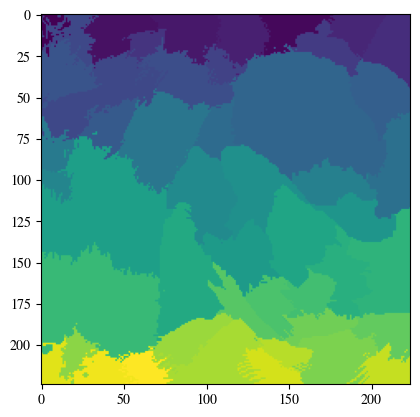

In [35]:
plt.imshow(segments)

In [36]:
segments.shape

(224, 224)

torch.Size([1, 224, 224])


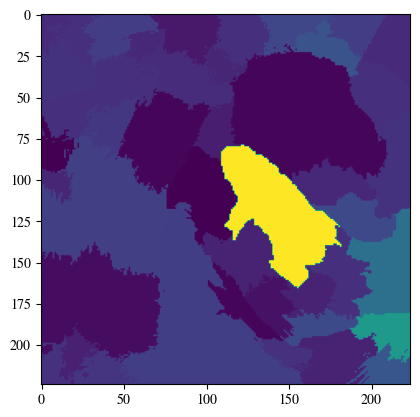

In [89]:
expln_scores = np.zeros_like(segments, dtype=float)
expln_flat_masks = np.zeros_like(segments, dtype=float)

for e_i, (k, v) in enumerate(explanation.items()):
    for s_i in k:
        expln_scores[segments == s_i] = v
        expln_flat_masks[segments == s_i] = e_i
plt.imshow(expln_scores)
expln_flat_masks = torch.tensor(expln_flat_masks).unsqueeze(0).to(device)
print(expln_flat_masks.shape)

In [45]:
expln_scores

array([[0.42529047, 0.42529047, 0.42529047, ..., 0.40848237, 0.40848237,
        0.40848237],
       [0.42529047, 0.5662061 , 0.42529047, ..., 0.40848237, 0.40848237,
        0.40848237],
       [0.5662061 , 0.42529047, 0.42529047, ..., 0.40848237, 0.40848237,
        0.40848237],
       ...,
       [0.6619823 , 0.6619823 , 0.6619823 , ..., 1.91241145, 1.91241145,
        1.91241145],
       [0.6619823 , 0.6619823 , 0.6619823 , ..., 1.91241145, 1.91241145,
        1.91241145],
       [0.6619823 , 0.6619823 , 0.6619823 , ..., 1.91241145, 1.91241145,
        1.91241145]])

In [50]:
from collections import namedtuple


class WrappedBackboneModelRaw(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, inputs):
        outputs = self.model(inputs, output_hidden_states=True)
        return outputs.logits

In [55]:
wrapped_backbone_model_raw = WrappedBackboneModelRaw(backbone_model)

expln_scores_tensor = torch.tensor(expln_scores).unsqueeze(0)

del_evaluator_bbm = DeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    del_score_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor)
del_score_archipelago

 99%|█████████▉| 223/225 [00:01<00:00, 136.44it/s]


tensor([0.2347], device='cuda:0')

 99%|█████████▉| 223/225 [00:01<00:00, 119.62it/s]


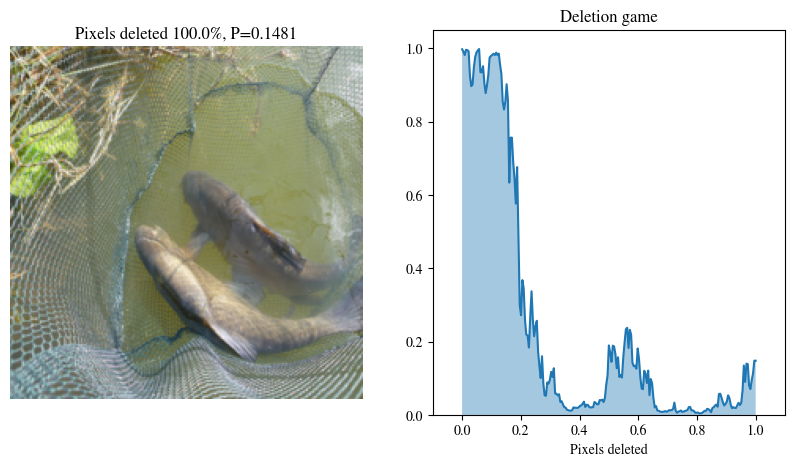

In [94]:
with torch.no_grad():
    del_eval_output_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago = del_eval_output_archipelago['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago[0])

 99%|█████████▉| 223/225 [00:01<00:00, 159.76it/s]


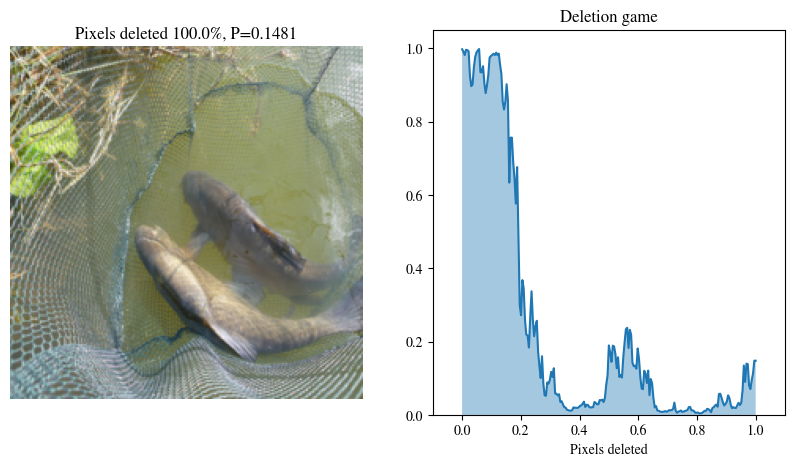

In [54]:
with torch.no_grad():
    del_eval_output_archipelago = del_evaluator_bbm(inputs, expln_scores_tensor, return_dict=True)
del_scores_archipelago = del_eval_output_archipelago['scores']
del_evaluator_bbm.plot(denormed_img[0], del_scores_archipelago[0])

In [90]:
gdel_evaluator_archipelago = GroupedDeletionCls(wrapped_backbone_model_raw)
with torch.no_grad():
    gdel_score_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks)
print(gdel_score_archipelago)

tensor([0.1272], device='cuda:0')


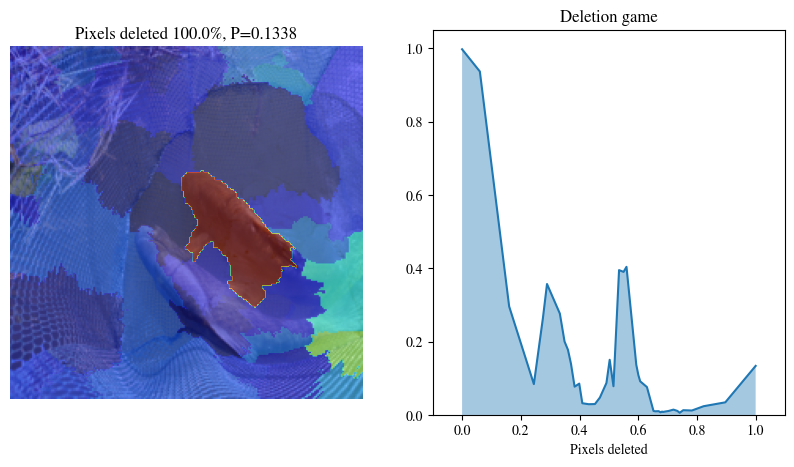

In [93]:
with torch.no_grad():
    gdel_eval_output_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gdel_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gdel_eval_output_archipelago['scores'][0], 
                                gdel_eval_output_archipelago['step_sizes'][0])

In [ ]:
with torch.no_grad():
    gdel_eval_output_archipelago = gdel_evaluator_archipelago(inputs, expln_scores_tensor, expln_flat_masks, return_dict=True)
gdel_evaluator_archipelago.plot(denormed_img[0], expln_scores_tensor, 
                                gdel_eval_output_archipelago['scores'][0], 
                                gdel_eval_output_archipelago['step_sizes'][0])